# Model hyper-parameter tuning & evaluation

## Abstract

This notebook runs the hyperparameter tuning of the production model.

The production model is an XGBoost regressor.
<br>The following features are used:

The hyperparameters to tune are:
- `max_depth` of the trees along the integer interval: `[3, 10]`
- `learning_rate` of the optimisation method across the log scale from `0.01` to `1`
- `n_estimators` or number of trees along the integer interval: `[50, 1000]`

We set a maximum of 20 trials.

_NB: for all trials, `gamma` is set to `0` while `subsample` to `1`._

__RMSE__ is used as the metric to evaluate for the hypertuning.

<br>During this stage, the process is the following:
- the _original training_ data is split into train/test sets in a 70% / 30% fashion;
- for each combination of hyperparameters values, a 5-fold cross validation happens on the train set;
- the average of the 5 RMSEs reported during cross-validation is used to quantify the performance of the hyperparameters values;
- with the same hyperparameters values, the model is trained on the entire train set then validated on the test set;
- the full picture of metrics during the test is serialized on Cloud Storage in the __modelling_serializations__ folder;
- with the hyperparameters values frozen, the model is fully trained on the _original training_ data (100% of data available) and saved in Cloud Storage in the __modelling_serializations__ folder.

## Hyperparameter tuning using Vertex AI

In [1]:
!gcloud ai hp-tuning-jobs create --region=europe-west3 --display-name="blackfriday_ml_hypertune" --max-trial-count=20 --parallel-trial-count=4 --config=hyperparam.yaml

Using endpoint [https://europe-west3-aiplatform.googleapis.com/]
Hyperparameter tuning job [7098077633014923264] submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud ai hp-tuning-jobs describe 7098077633014923264 --region=europe-west3

Job State: JOB_STATE_PENDING


From the [Vertex AI Hyperparameter Tuning Jobs Dashboard](https://console.cloud.google.com/vertex-ai/training/hyperparameter-tuning-jobs),

TODO: update hyperparameter values


the best model trained has the following hyperparameter values:
- `max_depth` = 9
- `learning_rate` = 0.31619
- `n_estimators` = 767
- `subsample` = 1
- `gamma` = 0

Let's freeze those hyperparameter values and make some additional experiments to have a more detailed picture.
<br>For instance, we will plot the distributions of predictions.

### Optimised XGBoost

2022/05/28 20:55:49 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000019E92FFAD38>)),
             ...`
2022/05/28 20:55:49 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x0000019E92FFAD38>)),
                               ...`
2022/05/28 20:55:49 WARNING mlflow.utils: Truncated the value of the key `regressor`. Truncated value: `XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
 

Training...


2022/05/28 21:03:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 452.67 s


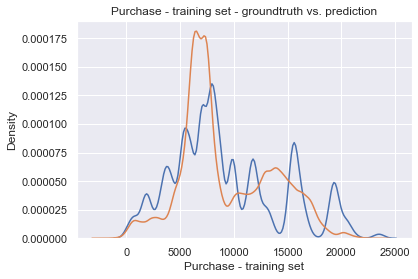

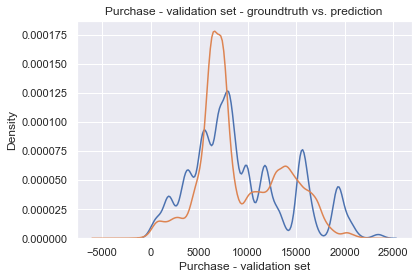

In [2]:
from sklearn.pipeline import Pipeline
from modelling.models import (
    get_imputed_preprocessor,
    train_eval,
    setup_mlflow
)
from data.data import import_data
from xgboost import XGBRegressor


# Set tracking URI and enable autologging 
setup_mlflow()

# Get training data
X, y = import_data("train.csv")

params = {
    'n_estimators': 767, 'learning_rate': 0.31619, 'max_depth': 9, 'subsample': 1.0, 'gamma': 0,
    'random_state': 0, 'n_jobs': -1
}

xgb_model, xgb_training_perf, xgb_test_perf = train_eval(
    X=X,
    y=y,
    model=Pipeline(steps=[
        ("preprocessor", get_imputed_preprocessor()),
        ("regressor", XGBRegressor(**params))
    ]),
    model_name="xgb_hypertuned",
    plot_preds=True
)

In [3]:
from pprint import pprint

pprint(xgb_training_perf)

{'MAE': 1679.1048390478481,
 'MedAE': 1320.7880859375,
 'R2': 0.8047268941827476,
 'RMSE': 2218.4921147431596,
 'explained_variance': 0.8047268943715813,
 'max_error': 12661.09375,
 'r2': 0.806794429401171}


In [4]:
pprint(xgb_test_perf)

{'MAE': 1874.3376298031108,
 'MedAE': 1440.7421875,
 'R2': 0.748109213010297,
 'RMSE': 2524.141382090673,
 'explained_variance': 0.7481092155718132,
 'max_error': 15559.359375,
 'r2': 0.7482615048293954}


TODO: update

Compared to the baseline showed in [Training experiments](https://6fbe85b20ee1f013-dot-datalab-vm-us-west1.googleusercontent.com/lab/tree/Demo%20#2/4.%20Training%20experiments.ipynb), we can highlight the following remarks:
- the XGBoost better learns on the training set (XGBoost RMSE = 2215 vs. baseline RMSE = 2451)
- however the XGBoost performs a little worse than the baseline on the test set (XGBoost RMSE = __2527__ vs. baseline RMSE = __2502__) - which is due to the more sophisticated nature of the ensemble of decision trees compared to a linear regression
- in terms of plots, the XGBoost really tries to fit to the groundtruth distribution while the baseline has a lazier & smoother behavior

At that stage, we can guess that the XGBoost could be better optimised with a longer hypertuning phase.
_Keep in mind that for the sake of a simple demonstration, we set the hypertuning phase to a maximum of 20 trials only, which is quite mean compared to the hyperparameter space to explore._
<br>Another consideration would be to even broaden the hyperparameter space to other hyperparameters like `gamma` or `subsample`.
<br>A last consideration would be to integrate some dimensionality reduction as a preprocessing step, like we did during the [Training experiments](https://6fbe85b20ee1f013-dot-datalab-vm-us-west1.googleusercontent.com/lab/tree/Demo%20#2/4.%20Training%20experiments.ipynb).

Let's make a last experiment by adding an SVD decomposition in prior of the XGBoost model.
<br>We will take an arbitrary number of `n_components` of `100` to embed our initial very high dimensionality feature space - like we did in prior.

## Hyperparameter tuning using Optuna

Models with short teaching times should be optimized locally for hyperparameters. Although the Vertex AI offers a good option, it is especially worth using for high-computational models, as jobs start up in a relatively long time.

Optuna is a hyperparameter optimization framework. It offers a good local alternative to Vertex AI. Other similar frameworks such as Hyperopt can also be used as well.

In [1]:
import optuna
from hyperparameter_optimization.hyperopt_w_optuna import objective


study = optuna.create_study(direction="minimize")
study.optimize(
    objective,
    n_trials=20
)

print(study.best_trial)

[I 2022-05-25 21:55:01,200] A new study created in memory with name: no-name-35349678-c159-40df-b134-d72fd0d9f56e
2022/05/25 21:55:04 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 21:55:04 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 21:55:04 WARNING mlflow.utils: Truncated the value of the key `regressor`. Truncated value: `XGBRegressor(base_score=None, booster=None, callbacks=None,
           

Training...


2022/05/25 21:59:17 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 252.96 s


[I 2022-05-25 21:59:33,627] Trial 0 finished with value: 2586.3009419959453 and parameters: {'max_depth': 9, 'learning_rate': 0.22908941489756757, 'n_estimators': 455}. Best is trial 0 with value: 2586.3009419959453.
2022/05/25 21:59:34 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 21:59:34 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 21:59:34 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/05/25 22:01:11 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 97.37 s


[I 2022-05-25 22:01:23,632] Trial 1 finished with value: 2589.521215423041 and parameters: {'max_depth': 3, 'learning_rate': 0.9328186334054349, 'n_estimators': 406}. Best is trial 0 with value: 2586.3009419959453.
2022/05/25 22:01:24 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:01:24 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:01:24 WARNING mlflow.utils: Truncated the value of the key `

Training...


2022/05/25 22:02:28 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 64.54 s


[I 2022-05-25 22:02:42,279] Trial 2 finished with value: 2852.702302053437 and parameters: {'max_depth': 9, 'learning_rate': 0.05746290793727885, 'n_estimators': 76}. Best is trial 0 with value: 2586.3009419959453.
2022/05/25 22:02:43 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:02:43 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:02:43 WARNING mlflow.utils: Truncated the value of the key `

Training...


2022/05/25 22:06:55 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 252.64 s


[I 2022-05-25 22:07:13,567] Trial 3 finished with value: 2750.235852019919 and parameters: {'max_depth': 8, 'learning_rate': 0.04482852477546414, 'n_estimators': 491}. Best is trial 0 with value: 2586.3009419959453.
2022/05/25 22:07:15 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:07:15 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:07:15 WARNING mlflow.utils: Truncated the value of the key 

Training...


2022/05/25 22:14:24 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 430.06 s


[I 2022-05-25 22:14:53,197] Trial 4 finished with value: 2570.670713052871 and parameters: {'max_depth': 9, 'learning_rate': 0.8610269700196123, 'n_estimators': 743}. Best is trial 4 with value: 2570.670713052871.
2022/05/25 22:14:54 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:14:54 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:14:54 WARNING mlflow.utils: Truncated the value of the key `r

Training...


2022/05/25 22:16:32 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 98.30 s


[I 2022-05-25 22:16:45,002] Trial 5 finished with value: 2658.8133515383224 and parameters: {'max_depth': 7, 'learning_rate': 0.46782229850598817, 'n_estimators': 131}. Best is trial 4 with value: 2570.670713052871.
2022/05/25 22:16:46 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:16:46 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:16:46 WARNING mlflow.utils: Truncated the value of the key 

Training...


2022/05/25 22:22:26 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 340.42 s


[I 2022-05-25 22:22:48,796] Trial 6 finished with value: 2745.570016160612 and parameters: {'max_depth': 9, 'learning_rate': 0.02714399945628983, 'n_estimators': 668}. Best is trial 4 with value: 2570.670713052871.
2022/05/25 22:22:49 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:22:49 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:22:49 WARNING mlflow.utils: Truncated the value of the key `

Training...


2022/05/25 22:23:45 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 56.43 s


[I 2022-05-25 22:23:54,812] Trial 7 finished with value: 2771.213852744361 and parameters: {'max_depth': 5, 'learning_rate': 0.24346835746901757, 'n_estimators': 136}. Best is trial 4 with value: 2570.670713052871.
2022/05/25 22:23:55 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:23:55 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:23:55 WARNING mlflow.utils: Truncated the value of the key `

Training...


2022/05/25 22:25:55 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 119.86 s


[I 2022-05-25 22:26:05,880] Trial 8 finished with value: 3003.9318412365624 and parameters: {'max_depth': 3, 'learning_rate': 0.013935448975596062, 'n_estimators': 726}. Best is trial 4 with value: 2570.670713052871.
2022/05/25 22:26:06 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:26:06 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:26:06 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/05/25 22:28:08 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 122.33 s


[I 2022-05-25 22:28:19,130] Trial 9 finished with value: 2561.3136959163025 and parameters: {'max_depth': 7, 'learning_rate': 0.783506495158681, 'n_estimators': 290}. Best is trial 9 with value: 2561.3136959163025.
2022/05/25 22:28:20 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:28:20 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:28:20 WARNING mlflow.utils: Truncated the value of the key `

Training...


2022/05/25 22:32:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 242.19 s


[I 2022-05-25 22:32:37,633] Trial 10 finished with value: 2643.1818082051113 and parameters: {'max_depth': 5, 'learning_rate': 0.12711948973214823, 'n_estimators': 994}. Best is trial 9 with value: 2561.3136959163025.
2022/05/25 22:32:38 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:32:38 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:32:38 WARNING mlflow.utils: Truncated the value of the ke

Training...


2022/05/25 22:35:27 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 168.76 s


[I 2022-05-25 22:35:39,618] Trial 11 finished with value: 2585.5758550626324 and parameters: {'max_depth': 10, 'learning_rate': 0.9426080571636657, 'n_estimators': 300}. Best is trial 9 with value: 2561.3136959163025.
2022/05/25 22:35:40 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:35:40 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:35:40 WARNING mlflow.utils: Truncated the value of the ke

Training...


2022/05/25 22:39:50 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 250.20 s


[I 2022-05-25 22:40:05,887] Trial 12 finished with value: 2531.5762220202546 and parameters: {'max_depth': 7, 'learning_rate': 0.39649337256506023, 'n_estimators': 714}. Best is trial 12 with value: 2531.5762220202546.
2022/05/25 22:40:06 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:40:06 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:40:06 WARNING mlflow.utils: Truncated the value of the k

Training...


2022/05/25 22:44:42 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 275.88 s


[I 2022-05-25 22:44:58,885] Trial 13 finished with value: 2532.8950536941775 and parameters: {'max_depth': 6, 'learning_rate': 0.3596580582838073, 'n_estimators': 919}. Best is trial 12 with value: 2531.5762220202546.
2022/05/25 22:44:59 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:44:59 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:44:59 WARNING mlflow.utils: Truncated the value of the ke

Training...


2022/05/25 22:49:04 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 245.60 s


[I 2022-05-25 22:49:20,459] Trial 14 finished with value: 2552.209753018929 and parameters: {'max_depth': 5, 'learning_rate': 0.3160366133498262, 'n_estimators': 987}. Best is trial 12 with value: 2531.5762220202546.
2022/05/25 22:49:21 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:49:21 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:49:21 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/05/25 22:53:27 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 246.16 s


[I 2022-05-25 22:53:42,954] Trial 15 finished with value: 2630.1396429271554 and parameters: {'max_depth': 6, 'learning_rate': 0.1328584750751401, 'n_estimators': 840}. Best is trial 12 with value: 2531.5762220202546.
2022/05/25 22:53:44 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:53:44 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:53:44 WARNING mlflow.utils: Truncated the value of the ke

Training...


2022/05/25 22:58:05 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 262.14 s


[I 2022-05-25 22:58:22,685] Trial 16 finished with value: 2520.994537486217 and parameters: {'max_depth': 6, 'learning_rate': 0.45692260016376657, 'n_estimators': 864}. Best is trial 16 with value: 2520.994537486217.
2022/05/25 22:58:23 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 22:58:23 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 22:58:23 WARNING mlflow.utils: Truncated the value of the key

Training...


2022/05/25 23:00:39 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 136.16 s


[I 2022-05-25 23:00:50,966] Trial 17 finished with value: 2582.759485551114 and parameters: {'max_depth': 4, 'learning_rate': 0.4557309977113402, 'n_estimators': 611}. Best is trial 16 with value: 2520.994537486217.
2022/05/25 23:00:52 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 23:00:52 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 23:00:52 WARNING mlflow.utils: Truncated the value of the key 

Training...


2022/05/25 23:05:28 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 276.48 s


[I 2022-05-25 23:05:45,765] Trial 18 finished with value: 2645.7531280187327 and parameters: {'max_depth': 7, 'learning_rate': 0.09570329879509207, 'n_estimators': 822}. Best is trial 16 with value: 2520.994537486217.
2022/05/25 23:05:46 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
             ...`
2022/05/25 23:05:46 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('clean',
                                                  FunctionTransformer(func=<function clean at 0x00000215A598DB88>)),
                               ...`
2022/05/25 23:05:46 WARNING mlflow.utils: Truncated the value of the ke

Training...


2022/05/25 23:09:45 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-05-13; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'gcp-ml-spec-demo-2'}


   Training time: 238.85 s


[I 2022-05-25 23:10:00,905] Trial 19 finished with value: 2597.940119547639 and parameters: {'max_depth': 8, 'learning_rate': 0.18359336326991016, 'n_estimators': 590}. Best is trial 16 with value: 2520.994537486217.


FrozenTrial(number=16, values=[2520.994537486217], datetime_start=datetime.datetime(2022, 5, 25, 22, 53, 42, 955892), datetime_complete=datetime.datetime(2022, 5, 25, 22, 58, 22, 685498), params={'max_depth': 6, 'learning_rate': 0.45692260016376657, 'n_estimators': 864}, distributions={'max_depth': IntUniformDistribution(high=10, low=3, step=1), 'learning_rate': LogUniformDistribution(high=1.0, low=0.01), 'n_estimators': IntUniformDistribution(high=1000, low=50, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=16, state=TrialState.COMPLETE, value=None)


TODO:

Compared to the baseline showed in [Training experiments](TODO), we can highlight the following remarks:
- the XGBoost better learns on the training set (XGBoost RMSE = 2215 vs. baseline RMSE = 2451)
- however the XGBoost performs a little worse than the baseline on the test set (XGBoost RMSE = __2527__ vs. baseline RMSE = __2502__) - which is due to the more sophisticated nature of the ensemble of decision trees compared to a linear regression
- in terms of plots, the XGBoost really tries to fit to the groundtruth distribution while the baseline has a lazier & smoother behavior

At that stage, we can guess that the XGBoost could be better optimised with a longer hypertuning phase.
_Keep in mind that for the sake of a simple demonstration, we set the hypertuning phase to a maximum of 20 trials only, which is quite mean compared to the hyperparameter space to explore._
<br>Another consideration would be to even broaden the hyperparameter space to other hyperparameters like `gamma` or `subsample`.
<br>A last consideration would be to integrate some dimensionality reduction as a preprocessing step, like we did during the [Training experiments](TODO).

Let's make a last experiment by adding an SVD decomposition in prior of the XGBoost model.
<br>We will take an arbitrary number of `n_components` of `100` to embed our initial very high dimensionality feature space - like we did in prior.